In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Imports
import torch
import torch.nn as nn
import pandas as pd
import copy
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import chisquare

In [3]:
from vae import VAE
from vae import GroupSoftmax
from trainer import Trainer

In [4]:
directory_path = '/mnt/c/Users/fabi8/Desktop/GNN'

In [5]:
# Device config 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

Device: cuda


In [51]:
#data_name = 'one_hot_allNaNs_agep.csv'
#model_name = 'model_allNaNs_agep.pth'
#
#data_name = 'one_hot_allNaNs_agep_small.csv'
#model_name = 'model_pNaNs_agep.pth'

data_name = 'one_hot_pNaNs_agep_small.csv'
#model_name = 'model_l100_h100_b1_g2'
model_name = 'model_l100_h500_b3_g2'

In [53]:
# load data 
data = pd.read_csv(f'{directory_path}/data/{data_name}')
data_tensor = torch.tensor(data.values, dtype=torch.float32)
# load model 
cols = list(data.columns)
cols = [col.split(":")[0] for col in cols]

onehot_counts = {col: sum(data.columns.str.startswith(f"{col}:")) for col in cols}
group_sizes = list(onehot_counts.values())
input_size = data.shape[1]

model = VAE(input_size, 500, 6, 100, group_sizes)
model.load_state_dict(torch.load(f'{directory_path}/models/{model_name}.pth'))
model.eval()

VAE(
  (encoder): Encoder(
    (layers): Sequential(
      (0): MLPBlock(
        (layers): Sequential(
          (0): Linear(in_features=433, out_features=500, bias=True)
          (1): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU()
        )
      )
      (1): ResidualBlock(
        (mlp1): MLPBlock(
          (layers): Sequential(
            (0): Linear(in_features=500, out_features=500, bias=True)
            (1): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU()
          )
        )
        (mlp2): MLPBlock(
          (layers): Sequential(
            (0): Linear(in_features=500, out_features=500, bias=True)
            (1): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU()
          )
        )
      )
      (2): ResidualBlock(
        (mlp1): MLPBlock(
          (layers): Sequential(
            (0): Linear(in_fea

In [54]:
# sample from the model 
n_samples = len(data_tensor)

# sample from the model
sample = model.pretrain_sample(n_samples)
predicted = sample.detach().cpu().numpy()
ground_truth = data_tensor.detach().cpu().numpy()

print(f'predicted: {predicted.shape}')
print(f'ground_truth: {ground_truth.shape}')


predicted: (3156, 433)
ground_truth: (3156, 433)


In [10]:
# prepare dicts and namings for plotting
labels = list(data.columns)
labels = [label.split(":") for label in labels]
feature_label_dict = {}
for key, label in labels:
    if key in feature_label_dict:
        feature_label_dict[key].append(label) 
    else:
        feature_label_dict[key] = [label]

indices = {}

for key, label in labels:
    if key in indices:
        indices[key].append(data.columns.get_loc(f"{key}:{label}"))
    else:
        indices[key] = [data.columns.get_loc(f"{key}:{label}")]

print(feature_label_dict)
print(indices)
#data_dict = {data.columns}

{'TEN': ['owned or mortgaged', 'rented'], 'HHL': ['english', 'spanish', 'other indo-european', 'asian and pacific island languages', 'other'], 'VEH': ['no vehicles', '1 vehicle', '2 vehicles', '3 vehicles', '4 or more vehicles'], 'HINCP': ['under 5k', '5k-10k', '10k-15k', '15k-20k', '20k-25k', '25k-35k', '35k-50k', '50k-75k', '75k-100k', '100k-150k', '150k+'], 'R65': ['no', 'yes'], 'R18': ['no', 'yes'], 'SEX_1': ['male', 'female', 'nan'], 'SEX_2': ['male', 'female', 'nan'], 'SEX_3': ['male', 'female', 'nan'], 'SEX_4': ['male', 'female', 'nan'], 'SEX_5': ['male', 'female', 'nan'], 'SEX_6': ['male', 'female', 'nan'], 'SEX_7': ['male', 'female', 'nan'], 'SEX_8': ['male', 'female', 'nan'], 'SEX_9': ['male', 'female', 'nan'], 'SEX_10': ['male', 'female', 'nan'], 'SEX_11': ['male', 'female', 'nan'], 'SEX_12': ['male', 'female', 'nan'], 'SEX_13': ['male', 'female', 'nan'], 'SEX_14': ['male', 'female', 'nan'], 'AGEP_1': ['under 5', '5-9', '10-14', '15-19', '20-24', '25-29', '30-34', '35-39', '

In [11]:
ten_dict = {key: [] for key in feature_label_dict['TEN']}
hhl_dict = {key: [] for key in feature_label_dict['HHL']}
veh_dict = {key: [] for key in feature_label_dict['VEH']}
hincp_dict = {key: [] for key in feature_label_dict['HINCP']}
sex_dict = {key: [] for key in feature_label_dict['SEX_1']}
education_dict = {key: [] for key in feature_label_dict['SCHL_1']}
age_dict = {key: [] for key in feature_label_dict['AGEP_1']}
r18_dict = {key: [] for key in feature_label_dict['R18']}
r65_dict = {key: [] for key in feature_label_dict['R65']}



# create dicts for the groups and their indices 
for key, labels in feature_label_dict.items():
    if 'SEX' in key:
        for idx, label in enumerate(labels):
            sex_dict[label].append(indices[key][idx])
    elif 'SCHL' in key:
        for idx, label in enumerate(labels):
            education_dict[label].append(indices[key][idx])
    elif 'AGEP' in key:
        for idx, label in enumerate(labels):
            age_dict[label].append(indices[key][idx])
    elif 'TEN' in key:
        for idx, label in enumerate(labels):
            ten_dict[label].append(indices[key][idx])
    elif 'HHL' in key:
        for idx, label in enumerate(labels):
            hhl_dict[label].append(indices[key][idx])
    elif 'VEH' in key:
        for idx, label in enumerate(labels):
            veh_dict[label].append(indices[key][idx])
    elif 'HINCP' in key:
        for idx, label in enumerate(labels):
            hincp_dict[label].append(indices[key][idx])
    elif 'R18' in key:
        for idx, label in enumerate(labels):
            r18_dict[label].append(indices[key][idx])
    elif 'R65' in key:
        for idx, label in enumerate(labels):
            r65_dict[label].append(indices[key][idx])


houshold = [ten_dict, hhl_dict, veh_dict, hincp_dict, r18_dict, r65_dict]
individuals = [sex_dict, education_dict, age_dict]

In [12]:
def probabilities_p(ground_truth, predicted, dict):
    gt_probs = []
    pred_probs = []

    for key in dict.keys():
        idxs = dict[key]
        vals = ground_truth[:, idxs]

        tmp = np.sum(vals)
        gt_probs.append(tmp / len(vals))

        # pred
        vals = predicted[:, idxs]
        pred_probs.append(np.mean(vals))
    
    gt_probs = np.array(gt_probs, dtype=np.float64)
    pred_probs = np.array(pred_probs, dtype=np.float64)

    gt_probs = gt_probs[:-1]/gt_probs[:-1].sum()
    pred_probs = pred_probs[:-1]/pred_probs[:-1].sum()

    return gt_probs, pred_probs

In [13]:
def probabilities_h(ground_truth, predicted, dict):
    gt_probs = []
    pred_probs = []

    idxs = np.array(list(dict.values())).flatten()
    # gt
    vals = ground_truth[:, idxs]
    tmp = np.sum(vals, axis=0)
    gt_probs = tmp / len(vals)

    # pred
    vals = predicted[:, idxs]
    pred_probs = np.mean(vals, axis=0)


    # normalize the probabilities
    gt_probs = np.array(gt_probs, dtype=np.float64)
    pred_probs = np.array(pred_probs, dtype=np.float64)

    gt_probs = gt_probs/gt_probs.sum()
    pred_probs = pred_probs/pred_probs.sum()
    return gt_probs, pred_probs

In [14]:
def plot_group(group_names, ground_truth, predicted, label_dict, category_list, household=False, path=None):
    fig, ax = plt.subplots(1, len(category_list), figsize=(len(category_list)*5, 5))
    labels = copy.deepcopy(label_dict)


    for i, category_dict in enumerate(category_list):
        if household:
            gt_mean, pr_mean = probabilities_h(ground_truth, predicted, category_dict)
            x = np.arange(len(labels[group_names[i]]))
        else:
            gt_mean, pr_mean = probabilities_p(ground_truth, predicted, category_dict)
            x = np.arange(len(labels[group_names[i]])-1)
        
        p_value = chisquare(gt_mean, pr_mean).pvalue
        width = 0.35

        if not household:
            labels[group_names[i]].remove('nan')

        keys = labels[group_names[i]]
        ax[i].bar(x - width/2, gt_mean, width, label='Ground Truth')
        ax[i].bar(x + width/2, pr_mean, width, label='Predicted')
        ax[i].set_ylabel('Probability')
        ax[i].set_title(group_names[i])
        ax[i].set_xticks(x)
        ax[i].set_xticklabels(keys)
        ax[i].legend()
        x_max = ax[i].get_xlim()[1]
        y_min, y_max = ax[i].get_ylim()

        ax[i].text(x_max - 0.05, y_min + (y_max - y_min) * 0.1,  # Adjusted for inside placement
                f'p-value: {p_value:.2f}', 
                fontsize=12, verticalalignment='bottom', horizontalalignment='right', 
                bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3'))
        ax[i].tick_params(axis='x', rotation=70)
    plt.tight_layout()
    plt.savefig(f'{path}.png', bbox_inches='tight')
    plt.show()
    plt.close()
        

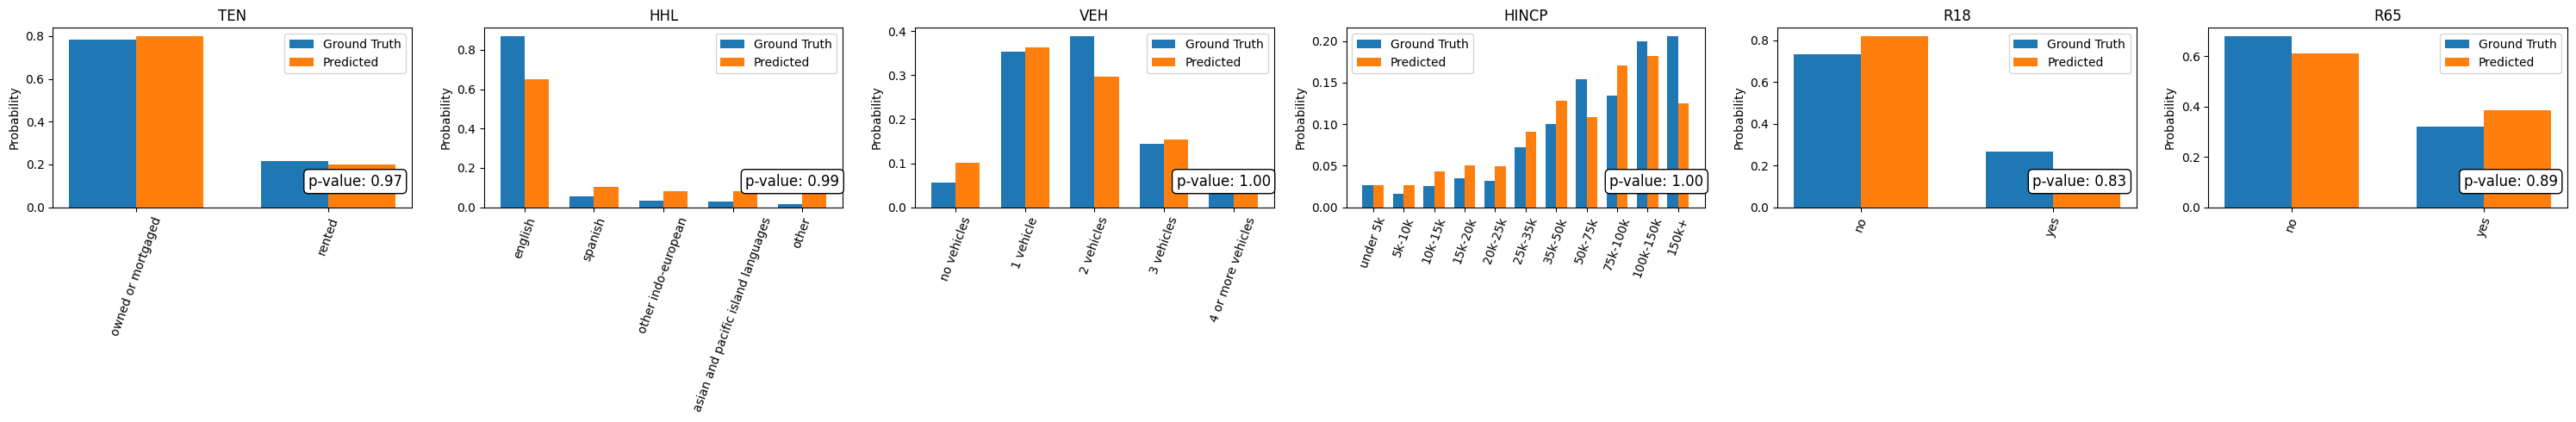

In [55]:
save_path = f'{directory_path}/GNN_Project/plots/household_{model_name}'

group_names = ['TEN', 'HHL', 'VEH', 'HINCP', 'R18', 'R65']  

plot_group(group_names, ground_truth, predicted, feature_label_dict, houshold, household=True, path=save_path)

#plot_group('TEN', ground_truth, predicted, feature_label_dict, ten_dict, household=True)
#plot_group('HHL', ground_truth, predicted, feature_label_dict, hhl_dict, household=True)
#plot_group('VEH', ground_truth, predicted, feature_label_dict, veh_dict, household=True)
#plot_group('HINCP', ground_truth, predicted, feature_label_dict, hincp_dict, household=True)
#plot_group('R18', ground_truth, predicted, feature_label_dict, r18_dict, household=True)
#plot_group('R65', ground_truth, predicted, feature_label_dict, r65_dict, household=True)

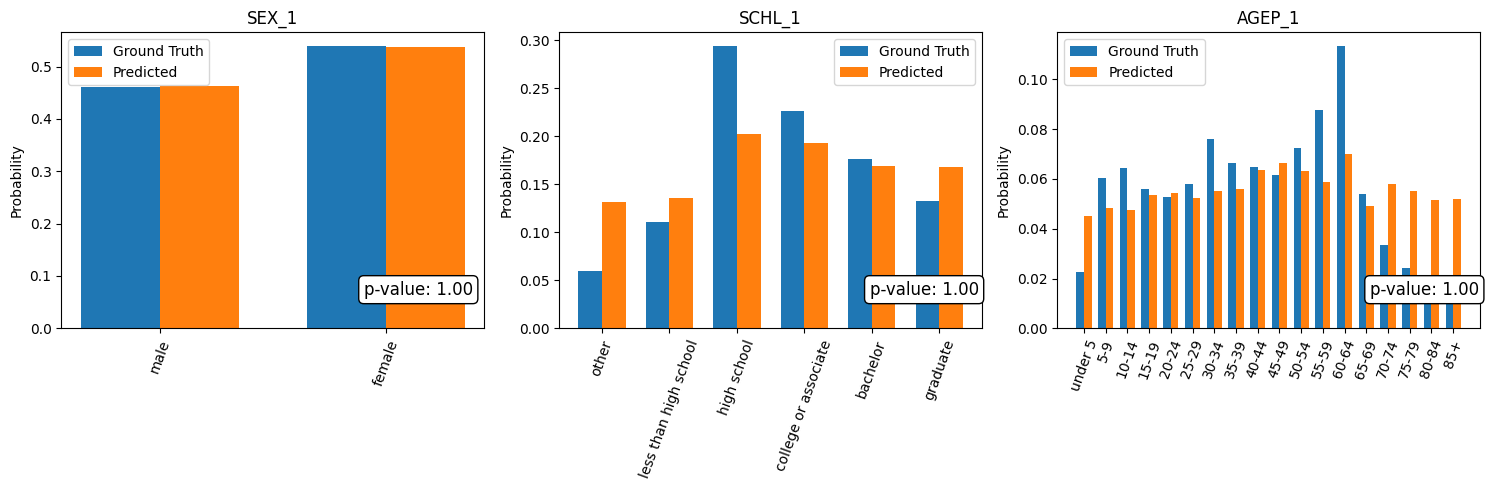

In [56]:
# plot the sex and education group without the average 

group_names = ['SEX_1', 'SCHL_1', 'AGEP_1']
save_path = f'{directory_path}/GNN_Project/plots/individual_{model_name}'
plot_group(group_names, ground_truth, predicted, feature_label_dict, individuals, household=False, path=save_path)

#plot_group('SEX_1', ground_truth, predicted, feature_label_dict, sex_dict)
#plot_group('SCHL_1', ground_truth, predicted, feature_label_dict, education_dict)
#plot_group('AGEP_1', ground_truth, predicted, feature_label_dict, age_dict)

# RSME and KL

In [ ]:
def rsme(gt, pred):
    gt_mean = np.mean(gt, axis=0)
    print(gt_mean.shape)
    pred_mean = np.mean(pred, axis=0)
    print(pred_mean.shape)
    return np.sqrt(np.mean((gt_mean-pred_mean)**2))

def kl_div(gt, pred, er):
    gt_mean = np.mean(gt, axis=0)
    pred_mean = np.mean(pred, axis=0)
    return np.mean((pred_mean+er)*np.log((pred_mean+er)/(gt_mean+er)))


In [ ]:
print(ten_dict)
tenList = []
for value in ten_dict.values():
    tenList += value
print(tenList)

{'owned or mortgaged': [0], 'rented': [1]}
[0, 1]


In [ ]:
print(rsme(ground_truth[:, tenList], predicted[:, tenList]))
print(kl_div(ground_truth[:, tenList], predicted[:, tenList], 1e-8))

(2,)
(2,)
0.009870227355478746
0.00014280590322249525


torch.Size([3156, 100])
(3156, 2)


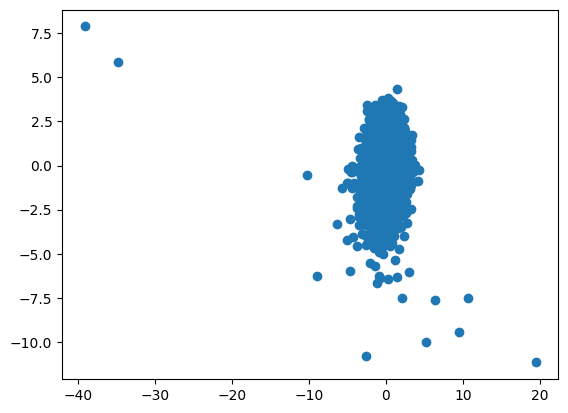

In [57]:
# check if encoded data is truly gaussian 
encoded, _, _ = model.encoder(data_tensor)
print(encoded.shape)
# apply pca to the encoded data
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca.fit(encoded.detach().cpu().numpy())
pca_data = pca.transform(encoded.detach().cpu().numpy())
print(pca_data.shape)
plt.scatter(pca_data[:, 0], pca_data[:, 1])
plt.show()